In [327]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
events = pd.read_csv("./filestore/events/fact_events.csv").drop('Unnamed: 0', axis=1)

In [3]:
events.head()

,description,duration,headcount,event_id,maybe_rsvp_count,name,rating,rsvp_limit,status,time,updated,utc_offset,venue_id,visibility,waitlist_count,yes_rsvp_count
0,These meetups are very informal. I won't be st...,9000000.0,12,147478282,0,PyLadies Dublin Inaugural meetup - bring laptop!,NaN,NaN,past,1384799400000,1384853013000,0,16176442,public,0,22
1,"Our second meetup will be at Engine Yard, a bi...",NaN,0,152107272,0,Second PyLadies Dublin Meetup - Let's get coding!,NaN,NaN,past,1387218600000,1387230236000,0,13054852,public,0,12
2,Happy New Year! Hope you all had a good Christ...,10800000.0,0,159368332,0,Our first PyLadies Dublin meetup of 2014,NaN,NaN,past,1390240800000,1390470097000,0,17757332,public,0,11
3,Bring your laptops along. If you want some foo...,10800000.0,0,162851382,0,PyLadies Dublin Feb meetup,NaN,NaN,past,1392660000000,1392672314000,0,18096492,public,0,9
4,!!!CHANGE OF VENUE UPDATE!!! &gt;&gt; More inf...,10800000.0,0,166955082,0,PyLadies Dublin Meetup,NaN,NaN,past,1395165600000,1395219566000,0,18950322,public,0,11


In [4]:
events.dtypes

description          object
duration            float64
headcount             int64
event_id             object
maybe_rsvp_count      int64
name                 object
rating              float64
rsvp_limit          float64
status               object
time                  int64
updated               int64
utc_offset            int64
venue_id              int64
visibility           object
waitlist_count        int64
yes_rsvp_count        int64
dtype: object

# Let's look at the event descriptions

In [5]:
desc = events['description'].tolist()

## Cleaning up the description

### Unicode, URLS, smiley faces

In [6]:
special_dict = {
    'smile' : r'[:;=]-[)D]?',
    'uni' : r'\xa0',
    'url' : r'(?:https?|ftp|file)://\S+',
    'uls_chars' :  r'(?:&[gla][tm]p?)+',
    'dupe_space' : r'\s{2,}|\s+\Z'
}

def remove_special(s):
    for k, regex in special_dict.items():
        if k == 'uni':
            s = re.sub(regex, ' ', s)
        elif k == 'dupe_space':
            s = re.sub(regex, ' ', s)
        else:
            s = re.sub(regex, '', s)
    return s

clean_special = [remove_special(s) for s in desc]

### Punctuation and emojis
There are some emoji characters and unwanted punctuation

In [7]:
def find_unwanted_chars(s):
#     pattern = r"[^a-zA-Z0-9\s.\-/':!?&@€$_+Éáéóć%]"
    pattern = r"[^a-zA-Z0-9\s/@€$_Éáéóć%]"
    return set(re.findall(pattern, s))

unwanted = set(char for e in desc for char in find_unwanted_chars(e))
clean_punct = []

for sent in clean_special:
    for punct in unwanted:
        sent = sent.replace(punct, "")
    clean_punct.append(sent)

# Removing words that have digits

Reason for this is that after tokenizing, I found that there are tokens which consist of digits (perhaps meetup start/end times)

In [8]:
def remove_digits(s):
    pattern = re.compile(r'\b(?:\d+\S+|\S+\d+)\b')
    return re.sub(pattern, '', s)

clean_digits = [remove_digits(s) for s in clean_punct]

# Cleaning duplicate spaces

In [9]:
regex = r'\s{2,}|\s+\Z'
event_corpus = [re.sub(regex, ' ', s).lower() for s in clean_digits]

# NLP to clean the text

In [10]:
import spacy
from spacy.lemmatizer import Lemmatizer
from spacy.lang.en import LEMMA_INDEX, LEMMA_EXC, LEMMA_RULES

nlp = spacy.load('en')

In [11]:
nlp_corpus = [nlp(sent) for sent in event_corpus]

In [12]:
entity_dict = {}
for entry in nlp_corpus:
    for entity in entry.ents:
        try:
            entity_dict[entity.label_].append(entity.text)
        except:
            entity_dict[entity.label_] = [entity.text]

In [13]:
entity_dict.keys()

dict_keys(['TIME', 'ORDINAL', 'DATE', 'MONEY', 'CARDINAL'])

In [14]:
lemmatized_corpus = [ ' '.join(word.lemma_.lower() if word.lemma_ != '-PRON-' else word.text for word in sent) for sent in nlp_corpus]

## Tokenizing and removing stop words

In [15]:
event_text = event_corpus

In [16]:
en_stopwords = stopwords.words('english')

In [17]:
from lda_stopwords import extra_stopwords
en_stopwords = en_stopwords + extra_stopwords

Vectorizer splits our documents into a distribution of words.
 
X is a term document matrix, where each document is a column and words are rows. The value associated to each cell is the TF-IDF

In [18]:
lemma_vectorizer = TfidfVectorizer(stop_words = set(en_stopwords))
lemma_dtm = lemma_vectorizer.fit_transform(lemmatized_corpus)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eaking'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [19]:
tfidf_vectorizer = TfidfVectorizer(stop_words = set(en_stopwords))
tfidf_dtm = tfidf_vectorizer.fit_transform(event_text)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eaking'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


The vectorizer we got above is used as input for LDA or NMF to build the model

# Exploring K-means Clustering

In [20]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist 

Since we don't have an idea of how many topics can there be, let's use the silhouette score as a measure of how many clusters we should have.

In [21]:
clusters = range(2,30)
distortions = []
silhouette_coeffs = []

for k in clusters:
    km = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10,verbose=0)
    km.fit(tfidf_dtm)
    
    distortions.append(km.inertia_)
    silhouette_coeffs.append(metrics.silhouette_score(tfidf_dtm, km.labels_))

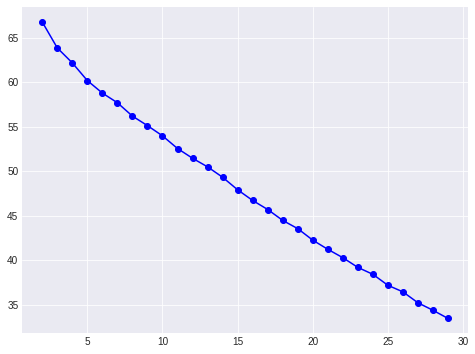

In [22]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(clusters, distortions, marker='o', color='b')
plt.show()

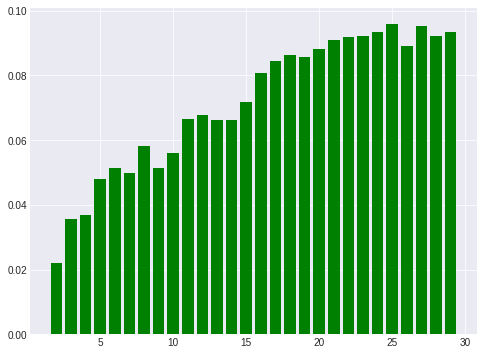

In [23]:
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(figsize=(8,6))

ax.bar(x=clusters, height=silhouette_coeffs, color='g')
plt.show()

It seems that the preprocessing done was not enough and the k-means algorithm is being too sensitive to the data. It could be worthwhile trying to extract the event descriptions manually as there are only 70 ish events...

Below a sample clustering for k=15, doesn't seem good.

In [24]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

for i in range(15):
    print("Cluster %d:" % i, end='')
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: salon phorest trello workflows deployment delivery tools continuous software fionnuala
Cluster 1: products communication marketing customer customers impersonal personally silo integrated page
Cluster 2: notes pythony things mailing discussions well list sharing join working
Cluster 3: ai landscape etsy projects work dive description emea entrepreneur comp
Cluster 4: workshop django website collab contribute pad tutorial data call tea
Cluster 5: network engineer principal lightning focus enterprise services hard pair dive
Cluster 6: society skills notes computer building branch promotion training lectures rate
Cluster 7: micropython provided workshop part need devices microcontroller attendees electronics microcontrollers
Cluster 8: lightning year project show api give example new help folks
Cluster 9: labs tech update pipenv scrapy circuit evening food numbers another
Cluster 10: graphite details speaking hackpad along fill meetup form hosted projects
Cluster 11: metricfire

# Exploring LDA

In [25]:
count_vectorizer = CountVectorizer(stop_words = set(en_stopwords))
X_count = count_vectorizer.fit_transform(event_text)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['eaking'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [26]:
count_df = pd.DataFrame(X_count.toarray(), columns= count_vectorizer.get_feature_names())

In [27]:
agg_counts = pd.DataFrame({
    'word' : count_vectorizer.get_feature_names(),
    'count' : count_df.T.apply(np.sum, axis=1)
}).reset_index(drop=True)

In [28]:
feats = count_vectorizer.get_feature_names()
digits = re.compile(r'^\d+')

print(f"There are {len(feats)} feature names.")
print(f"Of which {len([re.match(digits, f) for f in feats if re.match(digits, f)])} \
start with digits and might be noisy values")

There are 2088 feature names.
Of which 0 start with digits and might be noisy values


In [29]:
# agg_counts.sort_values('count', ascending=False).iloc[:50,:]

From looking at the counts above, the text quality doesn't look good. I will apply some manual cleansing to the description to get a more accurate representation of the Event descriptions

In [30]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [235]:
# Helper function
def print_topics(model, vectorizer, n_top_words):
    words = vectorizer.get_feature_names()
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        topic_themes = " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(topic_themes)
        topic_dict[topic_idx] = [topic_themes]
    return topic_dict


First, an attempt with just the CountVectorizer

In [236]:
# Tweak the two parameters below
number_topics = 20
number_words = 10
jobs = -1
max_iter = 25

alpha = None
eta = None

In [237]:
# Create and fit the LDA model
tfidf_lda = LDA(
    doc_topic_prior = alpha, 
    topic_word_prior = eta, 
    n_components=number_topics, 
    n_jobs = jobs, 
    max_iter=max_iter
)
tfidf_lda.fit(tfidf_dtm)

# Print the topics found by the LDA model
print("Topics found via LDA with tfidf vectorizer:")
tfidf_topics = print_topics(tfidf_lda, tfidf_vectorizer, number_words)

Topics found via LDA with tfidf vectorizer:

Topic #0:
january tomeasure customers run popular send engineers dashboards service second

Topic #1:
kx part accessibility micropython kdb coworkers turns nonverbal tue devices

Topic #2:
post tribalvc link charity hosted bucket sport supported hub scientists

Topic #3:
engine account pat shared havent username guys install windows helping

Topic #4:
kdb udemy contribute snacks goal forest random mnist got notebook

Topic #5:
token id digiwomen liquor drinks rooms fireroasted wings wonderful requirements

Topic #6:
apis craft flask principal focus enterprise hard doyou presenting endno

Topic #7:
salon phorest setting togie craftnight crafty tog geeky continuous lift

Topic #8:
thoughts society problem employee insights celery enterprises skills brand raising

Topic #9:
ai makers tool image tasks segmentation annotation hbc etsy indeed

Topic #10:
products marketing communication customer customers targeted teams product url integrated

Top

In [238]:
# Create and fit the LDA model with lemmatized text
lemmatized_lda = LDA(
    doc_topic_prior = alpha, 
    topic_word_prior = eta,
    n_components=number_topics, 
    n_jobs = jobs, 
    max_iter=max_iter
)
lemmatized_lda.fit(lemma_dtm)

# Print the topics found by the LDA model
print("Topics found via LDA with lemmatized vectorizer:")
lemmatized_topics = print_topics(lemmatized_lda, lemma_vectorizer, number_words)

Topics found via LDA with lemmatized vectorizer:

Topic #0:
thought design problem happen idea website big people along pyladie

Topic #1:
qualtric post tribalvc still link employee drop dropout dropin enquiry

Topic #2:
society certification buildingupdate hour rate promotion related relation branch national

Topic #3:
creation parsley parse programming design inspiration dream professionally bootstep bootstrappe

Topic #4:
salon hosting crafty craftnight togie tog phor geeky lift would

Topic #5:
sport startup independent hub commissioner council scientist enterprise office city

Topic #6:
pytorch udemy multiple metaclasse inheritance zalando jorge nov extensive bio

Topic #7:
measure advance programming attend startup pad language lead engineering heart

Topic #8:
meetup work project free bring workshop note question host laptop

Topic #9:
image scrapy indeed machine tool carlo metaanalysis annotation segmentation hbc

Topic #10:
engine github udemy today kubernete women username bi

To do:
* Review LDA model to understand how to fine tune alpha and eta
* Wordcloud for topics
* Match topics back to data and verify results

In [35]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

In [36]:
# tfidf_vis = pyLDAvis.sklearn.prepare(tfifd_lda, tfidf_dtm, tfidf_vectorizer)
# pyLDAvis.save_html(tfidf_vis, 'img/LDAvis tfidf.html')

In [37]:
# lemma_vis = pyLDAvis.sklearn.prepare(lemmatized_lda, lemma_dtm, lemma_vectorizer)
# pyLDAvis.save_html(lemma_vis, 'img/LDAvis lemmatized.html')

## Classifying our data

In [241]:
# Creates DF with mapping between topic # and topic names
topic_df = (
    pd.DataFrame(tfidf_topics)
    .T
    .reset_index()
    .rename(columns={'index':'topic_id', 0: 'topic'})
)

In [242]:
# Create document term matrix from event dataset
tfidf_categorised = tfidf_lda.transform(tfidf_vectorizer.transform(event_text))

In [243]:
# Creates dataframe with doc_id, topic, topic likelihood
tfidf_df = (
    pd.melt(
        pd.DataFrame(tfidf_categorised).reset_index(),
        id_vars=['index'],
        var_name=['topic_id'],
        value_name='likelihood')
    .rename(columns = {'index' : 'doc_id'})
    .sort_values(by=['doc_id', 'topic_id'])
    .reset_index(drop=True)
)

In [247]:
pyl_topics = pd.merge(tfidf_df, topic_df, on='topic_id', how='inner', validate='m:1', copy=False)

In [273]:
pyl_topics.groupby(level=0).max().head()

,doc_id,topic_id,likelihood,topic
0,0,0,0.009879,january tomeasure customers run popular send e...
1,1,0,0.008640,january tomeasure customers run popular send e...
2,2,0,0.006014,january tomeasure customers run popular send e...
3,3,0,0.005687,january tomeasure customers run popular send e...
4,4,0,0.005767,january tomeasure customers run popular send e...


How can I het the maximum likelihood for each doc/topic??

In [341]:
len(cmap.colors)

1500

/home/carlos/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


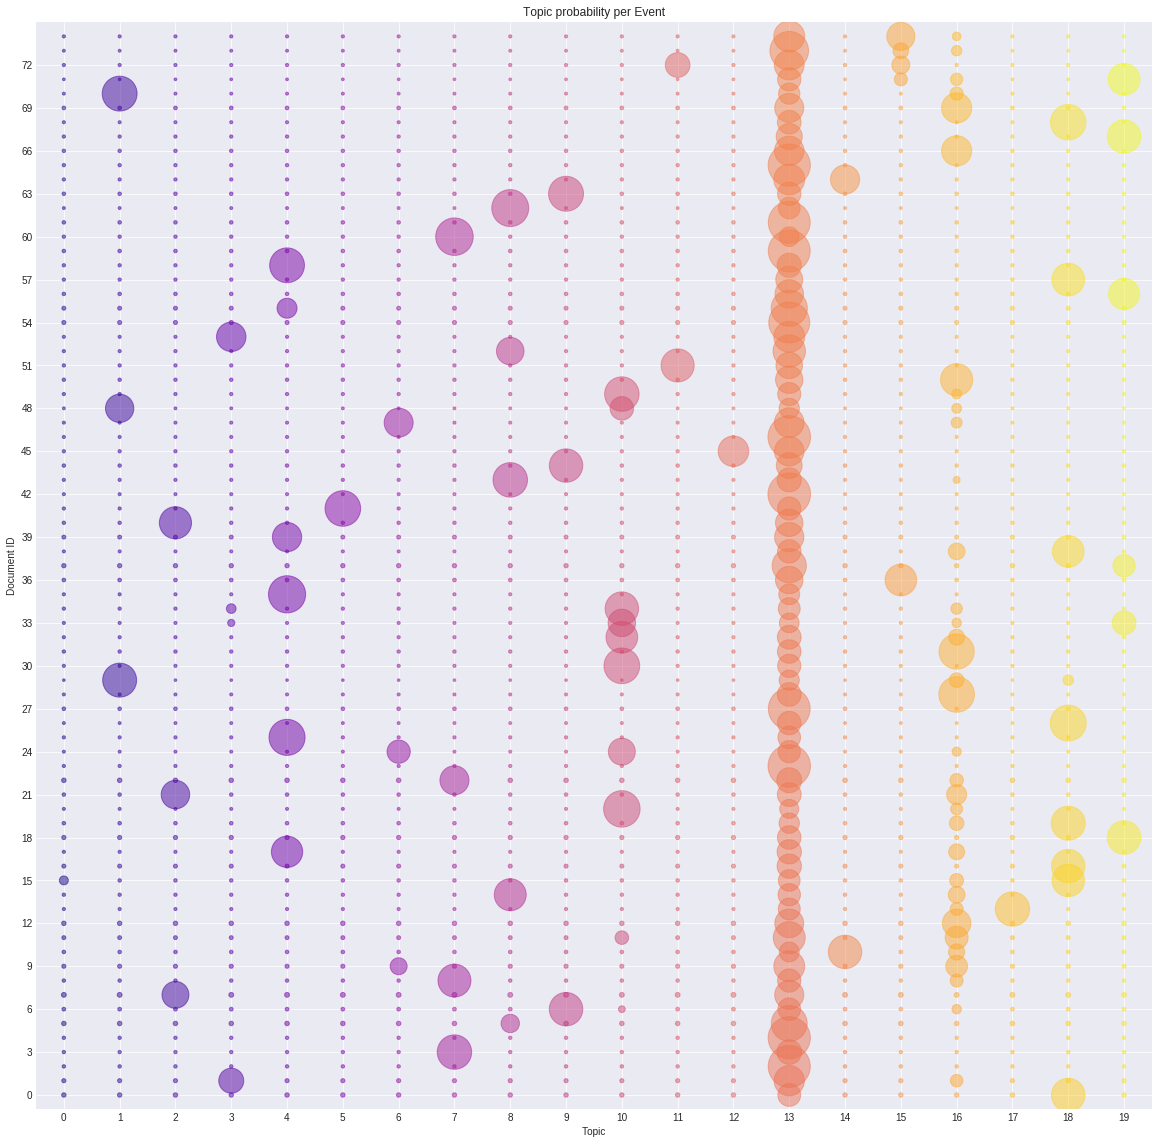

In [343]:
fig, ax = plt.subplots(figsize = (20,20))

cmap = cm.get_cmap('plasma', len(pyl_topics))
ax.scatter(
    x = pyl_topics['topic_id'],
    y = pyl_topics['doc_id'],
    s = pyl_topics['likelihood']*2000,
    marker = 'o',
    alpha = 0.5,
    c = cmap.colors,
    cmap = cmap
)
# Labels# 
ax.set_xlabel('Topic')
ax.set_ylabel('Document ID')
ax.set_title('Topic probability per Event')

# Axes 
ax.set_xlim(-0.5, 19.5)
ax.set_ylim(-1,75)
ax.set_xticks(range(number_topics))
ax.set_yticks(range(0,len(events), 3))

#Interact
ax.can_pan()
fig.show()